In [29]:
import argparse
import numpy as np
import seaborn as sns
from tools.fileOps import *
from tools.procOps import *
from tools.transcripts import *
from tools.bio import *
from pyfasta import Fasta
import pysam
from collections import *
from itertools import *
import pandas as pd

In [100]:
%pylab
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
figsize(6, 6)

Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib


In [147]:
#scaffold_fa = '/hive/users/ifiddes/notch2nl_berkeley_data/E2del19N_E2del68_combined_longranger/E2del68_E2del19N_combined/new-assembly/scaffolded.fa'
scaffold_fa = '/hive/users/ifiddes/notch2nl_berkeley_data/h9_hub/scaffolds/gene_region.fa'
scaffolds_bam = 'E2del68_E2del19N_combined.consensus_mapped.sorted.bam'
reads_fq = 'E2del68_E2del19N_combined.fastq'
tmp_fq = 'tmp.fq'
tmp_sam = 'tmp.sam'

cmd = ['samtools', 'fastq', scaffolds_bam]
run_proc(cmd, stdout=tmp_fq)
cmd = ['bwa', 'mem', '-t', '20', scaffold_fa, reads_fq]
run_proc(cmd, stdout=tmp_sam)

# load barcode map
bcode_map = {}
for x in open(reads_fq):
    if x.startswith('@'):
        name, bcode = x.split()
        name = name[1:-2]
        bcode_map[name] = bcode

# divide reads by barcode
sh = pysam.Samfile(tmp_sam)
s = defaultdict(list)
for x in sh:
    if not x.is_unmapped:
        bcode = bcode_map[x.qname]
        s[bcode].append(x)

In [148]:
test_bcode = 'GCCGTTTCAATGGCCC-1'
reads = s[test_bcode]
by_tgt = defaultdict(list)
for r in reads:
    by_tgt[r.reference_name].append([r, r.mapq])
avgs = {}
for rname, rname_vals in by_tgt.iteritems():
    rname_reads, mapqs = zip(*rname_vals)
    print rname, mapqs
    avgs[rname] = np.mean(mapqs)

NOTCH2NL-D-2 (0,)
NOTCH2NL-B-2 (0, 0, 0)
NOTCH2-1 (3, 0, 0)
NOTCH2NL-D-1 (0, 0, 0, 0, 0)
NOTCH2NL-A-2 (0, 0, 0)
NOTCH2NL-A-1 (0, 0, 0)
NOTCH2NL-C-1 (0, 0, 0)
NOTCH2NL-C-2 (0, 0, 0, 0, 3, 2)
NOTCH2-2 (0,)


In [3]:
reads = {'A1': '/hive/users/ifiddes/notch2nl_berkeley_data/E2del19N_E2del68_combined_longranger/E2del68_E2del19N_combined/new-assembly/results/AssembleBinsStep/c5/paired_binreads.fa',
        'A2': '/hive/users/ifiddes/notch2nl_berkeley_data/E2del19N_E2del68_combined_longranger/E2del68_E2del19N_combined/new-assembly/results/AssembleBinsStep/c6/paired_binreads.fa',
        'B1': '/hive/users/ifiddes/notch2nl_berkeley_data/E2del19N_E2del68_combined_longranger/E2del68_E2del19N_combined/new-assembly/results/AssembleBinsStep/c7/paired_binreads.fa',
        'B2': '/hive/users/ifiddes/notch2nl_berkeley_data/E2del19N_E2del68_combined_longranger/E2del68_E2del19N_combined/new-assembly/results/AssembleBinsStep/c8/paired_binreads.fa',
        'C1': '/hive/users/ifiddes/notch2nl_berkeley_data/E2del19N_E2del68_combined_longranger/E2del68_E2del19N_combined/new-assembly/reassemble_c9_k2/results/AssembleBinsStep/c0/paired_binreads.fa',
        'C2': '/hive/users/ifiddes/notch2nl_berkeley_data/E2del19N_E2del68_combined_longranger/E2del68_E2del19N_combined/new-assembly/reassemble_c9_k2/results/AssembleBinsStep/c1/paired_binreads.fa',
        'D1': '/hive/users/ifiddes/notch2nl_berkeley_data/E2del19N_E2del68_combined_longranger/E2del68_E2del19N_combined/new-assembly/reassemble_c4_k2/results/AssembleBinsStep/c0/paired_binreads.fa',
        'D2': '/hive/users/ifiddes/notch2nl_berkeley_data/E2del19N_E2del68_combined_longranger/E2del68_E2del19N_combined/new-assembly/reassemble_c4_k2/results/AssembleBinsStep/c1/paired_binreads.fa',
        'N1': '/hive/users/ifiddes/notch2nl_berkeley_data/E2del19N_E2del68_combined_longranger/E2del68_E2del19N_combined/new-assembly/results/AssembleBinsStep/c0/paired_binreads.fa',
        'N2': '/hive/users/ifiddes/notch2nl_berkeley_data/E2del19N_E2del68_combined_longranger/E2del68_E2del19N_combined/new-assembly/results/AssembleBinsStep/c1/paired_binreads.fa'}

In [4]:
truth = defaultdict(set)
for name, path in reads.iteritems():
    for l in open(path):
        if l.startswith('>'):
            bcode = l.split()[1]
            truth[name].add(bcode)

In [170]:
# find haplotype with highest average mapq
by_avg = {}
for bcode, reads in s.iteritems():
    if len(reads) < 10:
        continue
    by_tgt = defaultdict(list)
    for r in reads:
        by_tgt[r.reference_name].append([r, r.mapq])
    avgs = {}
    for rname, rname_vals in by_tgt.iteritems():
        rname_reads, mapqs = zip(*rname_vals)
        avgs[rname] = np.mean(mapqs)
    ordered = sorted(avgs.iteritems(), key=lambda x:x[1])
    best_name, best_score = ordered[-1]
    if (len(ordered) > 1 and best_score > ordered[-2][1]) or len(ordered) == 1:
    #if (len(ordered) > 1 and best_score > (ordered[-2][1] + 2)) or len(ordered) == 1:
        mappings = [x for x in reads if x.reference_name == best_name]
        by_avg[bcode] = mappings

In [171]:
# transform bcodes

# fix names
name_map = {'A1': 'NOTCH2NL-A-1', 'A2': 'NOTCH2NL-A-2',
           'B1': 'NOTCH2NL-B-1', 'B2': 'NOTCH2NL-B-2',
           'C1': 'NOTCH2NL-C-1', 'C2': 'NOTCH2NL-C-2',
           'D1': 'NOTCH2NL-D-1', 'D2': 'NOTCH2NL-D-2',
           'N1': 'NOTCH2-1', 'N2': 'NOTCH2-2'}
name_map = {y: x for x, y in name_map.iteritems()}

bcodes_by_ref = defaultdict(set)
for bcode, mappings in by_avg.iteritems():
    name = name_map[mappings[0].reference_name]
    bcodes_by_ref[name].add(bcode)

In [172]:
# construct confusion matrix
m = []
names = sorted(truth.keys())
for outer_name in names:
    truth_set = truth[outer_name]
    l = []
    for inner_name in names:
        test_set = bcodes_by_ref[inner_name]
        l.append(len(test_set & truth_set))
    m.append(l)

df = pd.DataFrame(m, columns=names)
df.index = names

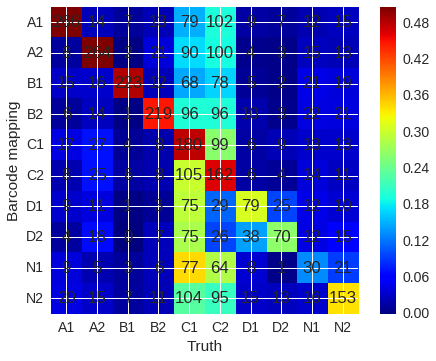

In [184]:
m = np.array(m)
norm_conf = []
for i in m:
    a = 0
    tmp_arr = []
    a = sum(i, 0)
    for j in i:
        tmp_arr.append(float(j)/float(a))
    norm_conf.append(tmp_arr)

fig = plt.figure()
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.array(norm_conf), cmap=plt.cm.jet, 
                interpolation='nearest')

width, height = m.shape

for x in xrange(width):
    for y in xrange(height):
        ax.annotate(str(m[x][y]), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center')

cb = fig.colorbar(res)
plt.xticks(range(width), names[:width])
plt.yticks(range(height), names[:height])
plt.xlabel("Truth")
plt.ylabel('Barcode mapping')

In [186]:
# transform to be by-ref
by_ref_avg = defaultdict(list)
by_ref_sum = defaultdict(list)
for bcode, mappings in by_avg.iteritems():
    mapqs = [x.mapq for x in mappings]
    avg = np.mean(mapqs)
    by_ref_avg[mappings[0].reference_name].append(avg)
    by_ref_sum[mappings[0].reference_name].append(sum(mapqs))

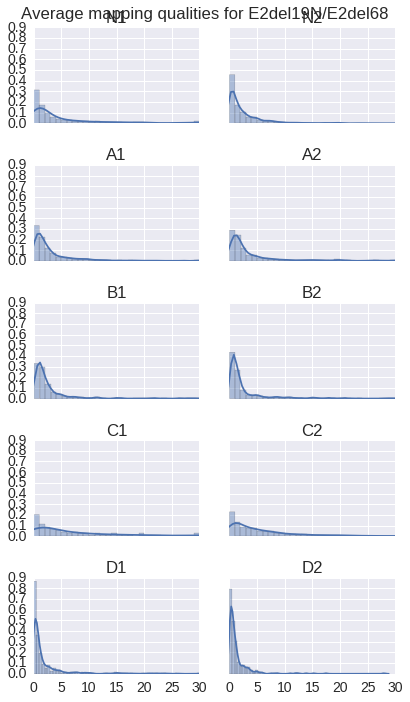

In [194]:
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True)
figsize(6, 10)
axes = iter(axes.flat)
axes[0].set_xlim(0, 30)
for name, avg_vals in sorted(by_ref_avg.iteritems(), key=lambda x: x[0]):
    name = name_map[name]
    g = sns.distplot(avg_vals, ax=axes.next(), bins=60)
    g.set_title(name)
plt.tight_layout()
fig.suptitle('Average mapping qualities for E2del19N/E2del68')

In [199]:
# find delta to next best again, separate delta by name
# find haplotype with highest average mapq
delta_avg = defaultdict(list)
for bcode, reads in s.iteritems():
    if len(reads) < 10:
        continue
    by_tgt = defaultdict(list)
    for r in reads:
        by_tgt[r.reference_name].append([r, r.mapq])
    avgs = {}
    for rname, rname_vals in by_tgt.iteritems():
        rname_reads, mapqs = zip(*rname_vals)
        avgs[rname] = np.mean(mapqs)
    if all([x == 0 for x in avgs.itervalues()]):
        continue
    ordered = sorted(avgs.iteritems(), key=lambda x:x[1])
    best_name, best_score = ordered[-1]
    best_name = name_map[best_name]
    if len(ordered) > 1:
        if ordered[-2][1] == 0:
            continue
        delta = ordered[-1][1] - ordered[-2][1]
        name = ordered[-2][0]
        name = name_map[name]
        delta_avg[best_name].append([name, delta])
        

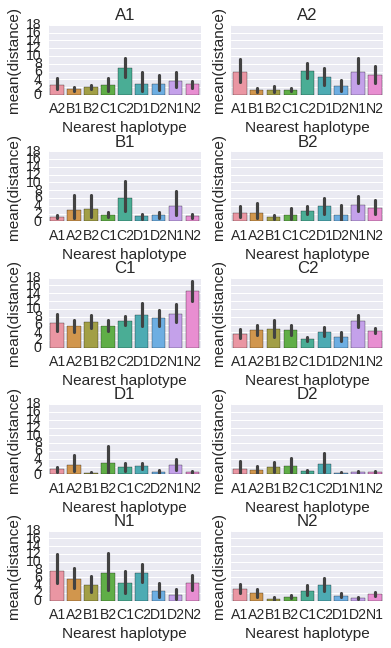

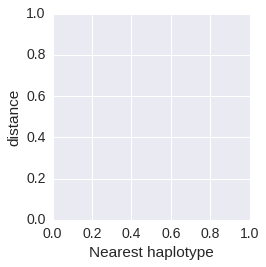

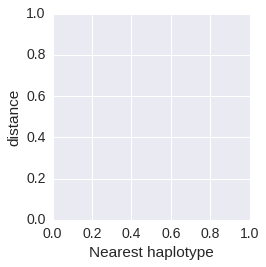

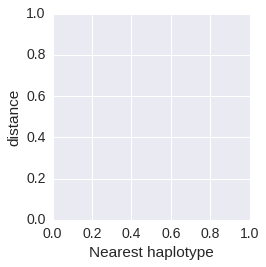

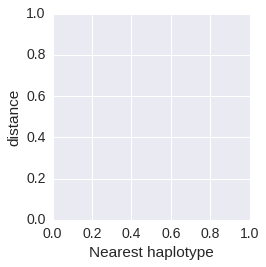

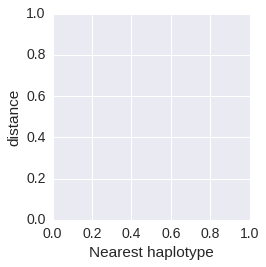

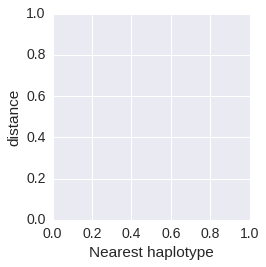

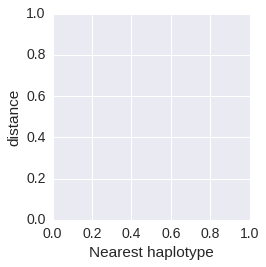

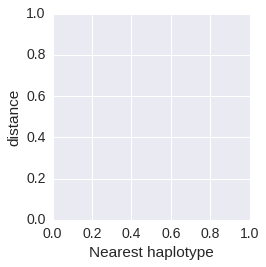

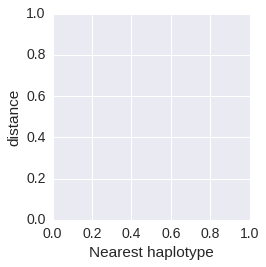

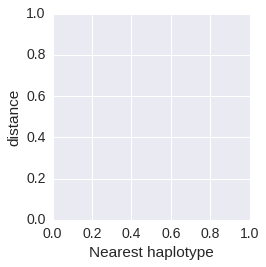

In [200]:
# for each reference, construct a plot showing the closest score
fig, axes = plt.subplots(nrows=5, ncols=2, sharey=True)
figsize(6, 10)
axes = iter(axes.flat)
plt.subplots_adjust(bottom=0.1, top=0.9, hspace=0.8)
for name, vals in sorted(delta_avg.iteritems(), key=lambda x: x[0]):
    df = pd.DataFrame(vals, columns=['Nearest haplotype', 'distance']).sort_values('Nearest haplotype')
    ax = axes.next()
    g = sns.factorplot(data=df, y='distance', kind='bar', x='Nearest haplotype', ax=ax)
    ax.set_title(name)
